# Home assignment 1

### Deadline: 4th December, 2024 at 23:59 CET

### Name:
### Student No.:

In this assignment we go through the following topics:
- Making a Data set class that inherits from `torch.utils.data.Dataset`
- Data Augmentation
- Transfer Learning or Fine Tuning
- Making a function for training

We are going to implement an image segmentation model for a pet dataset. We will use a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model.

### Image Segmentation

In an image segmentation task, a class is assigned to each pixel of the image.

Image segmentation is typically used to locate objects and boundaries in images and has many applications in medical imaging, self-driving cars and satellite imaging, for example.


This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (Parkhi et al, 2012). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

   * Class 1: Pixel belonging to the pet.
   * Class 2: Pixel bordering the pet.
   * Class 3: None of the above/a surrounding pixel.

### Setup


In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import (
    MaskRCNN_ResNet50_FPN_Weights,
    MaskRCNNPredictor,
)
from torchvision.transforms import functional

# Define a directory where you want to store the dataset
# We recommend using Colab, if you do not have a GPU!
#colab_dir = "./testing/ColabNotebooks/"  # Update this with your directory

# Load the dataset using the updated paths
#pets_path_train = os.path.join(colab_dir, "OxfordPets", "train")
#pets_path_test = os.path.join(colab_dir, "OxfordPets", "test")


### Define Datasets
The dataset consists of `(image, mask)` tuples. The image is a standard RGB PIL image. The masks are a single-channel PIL image where each pixel is one of the three category label values (0, 1 or 2).
PIL images can be transformed to Tensors using [torchvision.transforms.functional.pil_to_tensor](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.functional.pil_to_tensor) or vice-versa with [torchvision.transforms.functional.to_pil_image](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.functional.to_pil_image).

In [4]:
# # Define the dataset and test dataset
dataset = torchvision.datasets.OxfordIIITPet(
    root="./train_dataset",
    split="trainval",
    target_types="segmentation",
    download=True,
)
dataset_test = torchvision.datasets.OxfordIIITPet(
    root="./test_dataset",
    split="test",
    target_types="segmentation",
    download=True,
)

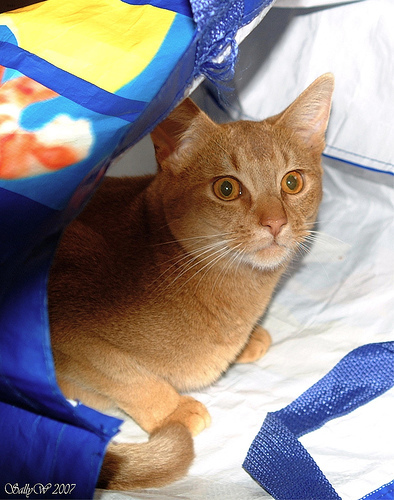

In [5]:
image, mask = dataset[0]

image

In [6]:
# Print the mask Tensor
functional.pil_to_tensor(mask).shape

torch.Size([1, 500, 394])

### Define transforms

These transforms augment the training data to improve the robustness of the model.
Use at least 3 different transforms for augmenting the data. 
The transforms should augment the image, e.g., distort, crop or rotate.
Transforms that only convert the image to Tensors do not count as augmentation.

See https://pytorch.org/vision/0.11/transforms.html for a list of all transforms.


In [7]:
# Define image transforms
image_transforms = transforms.Compose([
    transforms.Resize((200, 200)),  # Resize both image and mask
    transforms.ToTensor(),  # Convert image to tensor
])


### Define Collate Functions and Dataloaders
Notes:
- You do not have to use collate functions. However they are an easy way to apply methods to and order the data. The data is given as a list of `(image, mask)` tuples, but depending on your implementation, it may be beneficial to load the batches as a tuple of lists, i.e., `([images], [masks])`. The required reordering can be achieved using a collate function.
- Apply the above transforms to the training data. Keep in mind, you should apply the same transforms to the image and mask.
- The model requires a binary mask. Set all pixels that are not the pet in the image to 0.
- You should use a separate collate function for the train and test set. The test set does not need to be transformed, but converted to tensors.

In [8]:
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.transforms import functional as F
import torch

# Dataset wrapper to add synchronized transformations
class TransformedDataset(Dataset):
    def __init__(self, base_dataset, image_transform=None):
        """
        :param base_dataset: The original dataset
        :param image_transform: Transformations applied to both image and mask
        """
        self.base_dataset = base_dataset
        self.image_transform = image_transform

    def __getitem__(self, idx):
        # Get the original image and mask
        image, mask = self.base_dataset[idx]
        
        # do random transformations
        image = self.image_transform(image)
        mask = self.image_transform(mask)

        #random horizontal flip
        if torch.rand(1) > 0.5:
            image = F.hflip(image)
            mask = F.hflip(mask)
        
        #random vertical flip
        if torch.rand(1) > 0.5:
            image = F.vflip(image)
            mask = F.vflip(mask)
        
        #random rotation
        if torch.rand(1) > 0.5:
            angle = torch.randint(0, 360, (1,)).item()
            image = F.rotate(image, angle)
            mask = F.rotate(mask, angle)
        
        #random crop
        if torch.rand(1) > 0.5:
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(200, 200))
            image = F.crop(image, i, j, h, w)
            mask = F.crop(mask, i, j, h, w)

        transformed_image = image
        transformed_mask = mask
        return transformed_image, transformed_mask

    def __len__(self):
        return len(self.base_dataset)

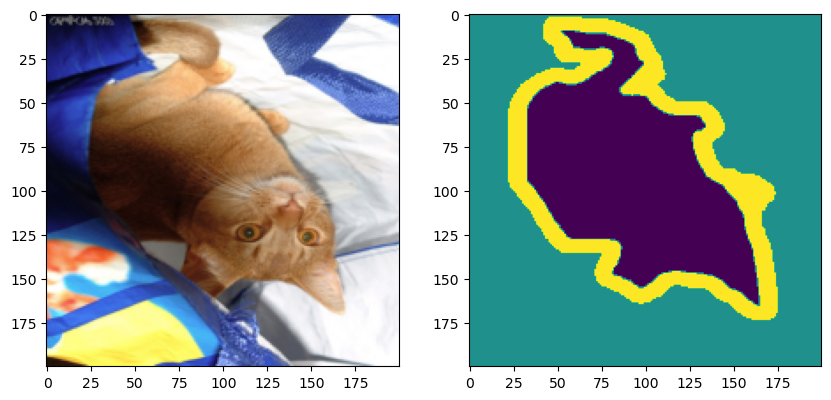

torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])


In [9]:
import matplotlib.pyplot as plt
# Wrap datasets with transformations
transformed_dataset = TransformedDataset(dataset, image_transforms)
transformed_dataset_test = TransformedDataset(dataset_test, image_transforms)

# Example usage
image, target = transformed_dataset[0]
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(target.permute(1, 2, 0))
plt.show()
type(target)

#check the shape of every image
for i in range(0, 10):
    image, target = transformed_dataset[i]
    print(image.shape)

In [10]:
def collate_train(batch):
    images, masks = zip(*batch)  # Unpack the batch into images and masks
    images = torch.stack(images)  # Combine images into a single tensor
    masks = torch.stack(masks)  # Combine masks into a single tensor
    return images, masks

def collate_test(batch):
    images, masks = zip(*batch)  # Unpack the batch into images and masks
    images = torch.stack(images)  # Combine images into a single tensor
    return images, masks

# Create data loaders for training and testing (using DIFFERENT collate functions!)
# Feel free to use custom hyperparameters
batch_size = 4
data_loader = DataLoader(
    dataset=transformed_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=2,
    # collate_fn=collate_train,
)
data_loader_test = DataLoader(
    dataset=transformed_dataset_test, batch_size=1, shuffle=False, num_workers=2
)

### Example images
To check that the masks and transforms are calculated correctly, plot four images, their masks, the transformed version and the corresponding mask.

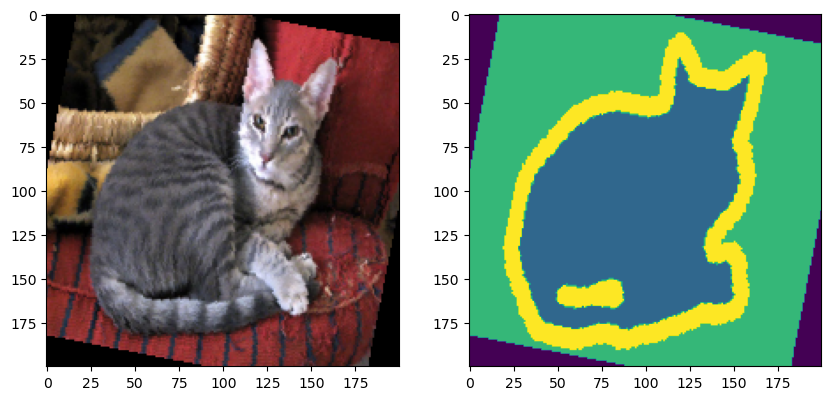

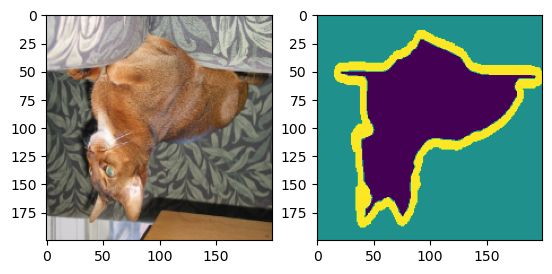

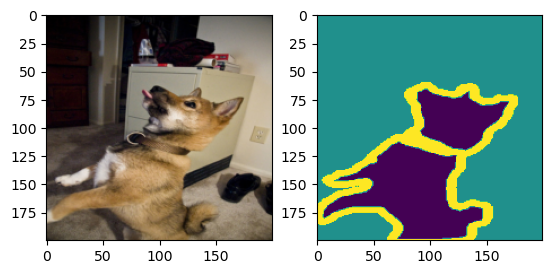

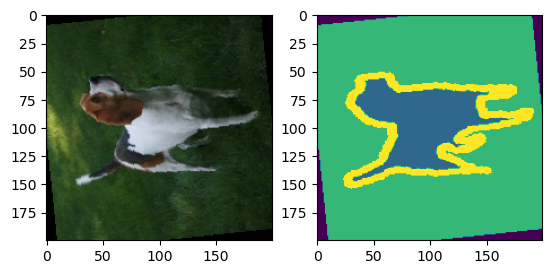

In [11]:
plt.figure(figsize=(10, 10))
# Visualize original and augmented versions of four images
for images, masks in data_loader:
    # Visualize the augmented images and masks
    for j in range(batch_size):
        plt.subplot(1, 2, 1)
        plt.imshow(images[j].permute(1, 2, 0))
        plt.subplot(1, 2, 2)
        plt.imshow(masks[j].permute(1, 2, 0))
        plt.show()
    break


### Introduction to transfer learning


* Transfer learning is an ML methods to **reuse a pre-trained model** on a new problem by exploiting the knowledge gained from a previous task to improve generalization about another similar task.
* Steps:
  1. Select a pre-trained source model
  2. Adapt the source model to create the target model
  3. Fine-tuning: Train source model to achieve the target model
* Strategies for fine-tuning of model:
* There are different **strategies for fine-tuning** the model: You can train the entire model or only some layers and leave the others frozen. Usually, if you have a small dataset and a large number of parameters, you will leave more layers frozen to avoid overfitting. By contrast, if the dataset is large and the number of parameters is small, you can improve your model by training more layers to the new task since overfitting is not an issue.
* **Main benefits:** less training data needed, better initial model, higher learning rate, faster training, higher accuracy after training
* **Example:** In training a classifier to predict the animal species, you could use the knowledge it gained during training to recognize dog breeds.


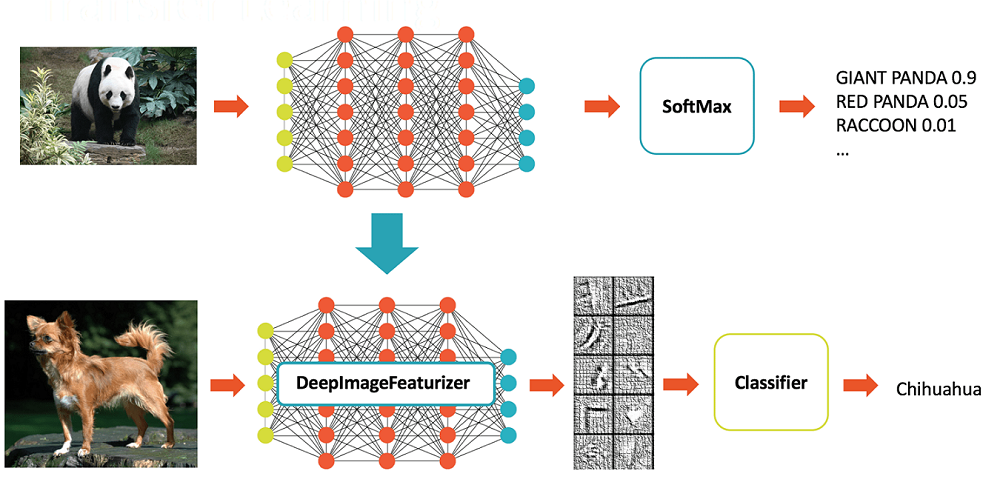

### Defining model and Prediction

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

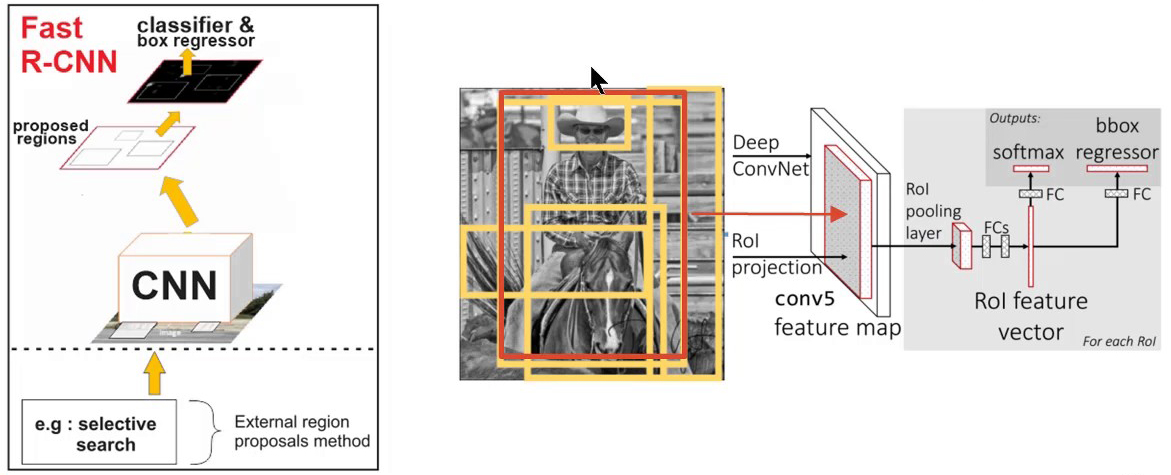


Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

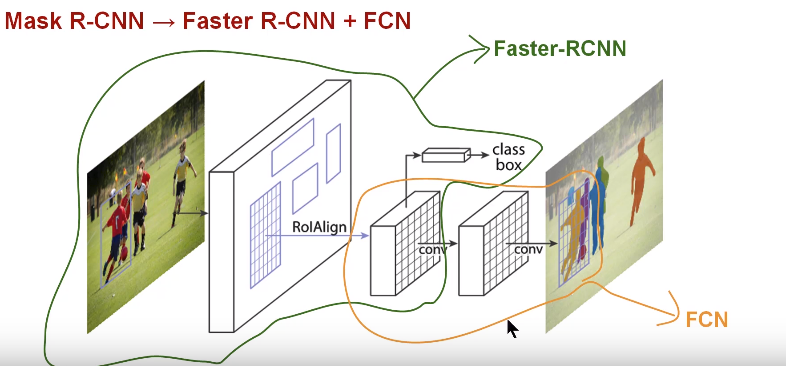





One of popular ways to modify models in torchvision modelzoo when we want to use a pre-trained model, and just finetune the last layer is transfer learning. In our task we want to also compute the segmentation masks, so we will be using Mask R-CNN.

### Define some hyperparameters:
Feel free to test some other options

In [12]:
NUM_CLASSES = 3
HIDDEN_LAYER = 256
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

This part initializes the model, optimizer and learning rate scheduler.

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Model Setup:
# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT
)

# Get the number of input features for the classifier and replace the head for the box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the head for the box predictor with FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# Get the number of input features for the mask classifier and replace the mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# Replace the mask predictor with MaskRCNNPredictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask, HIDDEN_LAYER, NUM_CLASSES
)

# Move the model to the appropriate device
model.to(device)


# Optimizer and Learning Rate Scheduler:
# Create an optimizer with proper lr, momentum, and weight decay
optimizer = torch.optim.SGD(
    model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001
)

# Create a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /Users/amirrezaalasti/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:16<00:00, 10.8MB/s] 


Some notes that may or may not be applicable to you:
- You may have to check if a bounding box is valid (i.e., contains foreground and is not 0-width or 0-height)
- Filter out all masks that have invalid bounding boxes

Now, let’s make a function for training each epoch:

In [25]:
# data_transforms = transforms.Compose(
#     [
#         transforms.ToTensor(),
#     ]
# )


def get_boxes(mask):
    pos = mask.squeeze().nonzero()
    boxes = torch.as_tensor(
        [
            torch.min(pos[:, 1]),
            torch.min(pos[:, 0]),
            torch.max(pos[:, 1]),
            torch.max(pos[:, 0]),
        ],
        dtype=torch.int64,
    ).unsqueeze(0)
    return boxes


def train(model, optimizer, dataloader, device, epoch, num_epochs, print_freq=1):
    model.train()  # Set the model to training mode

    # Loop through batches in the dataloader
    for images, masks in dataloader:
        # Convert the PIL Images to PyTorch tensors and move them to the correct device
        images = [image.to(device) for image in images]
        masks = [mask.to(device) for mask in masks]

        # Prepare the target format for each image
        targets = [
            {
                "boxes": get_boxes(masks[i]).to(device),
                "labels": torch.ones(1, dtype=torch.int64).to(device),  # Assuming a single class (label 1)
                "masks": masks[i],
                "image_id": torch.tensor([i], dtype=torch.int64).to(device),
            }
            for i in range(len(images))
        ]

        # Zero the gradients for the optimizer
        optimizer.zero_grad()

        # Forward pass: Get model predictions
        outputs = model(images, targets)

        total_loss = sum(outputs[key] for key in outputs if 'loss' in key)
        print(total_loss)

        # Backpropagate the loss and optimize the model
        total_loss.backward()
        optimizer.step()

    # Print the loss for the current epoch
    # if epoch % print_freq == 0:
    print(f"Epoch: [{epoch}/{num_epochs}], Loss: {total_loss.item():.4f}")


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [28]:
# use gpu if available on macbook

device(type='cpu')

In [26]:
# Update the number of epochs
num_epochs = 10

# TODO: Update the dataloader *if needed*

# Call the train function
for epoch in range(num_epochs):
    train(model, optimizer, data_loader, device, epoch, print_freq=10, num_epochs=num_epochs)
    lr_scheduler.step()


tensor(0.2426, grad_fn=<AddBackward0>)
tensor(0.1937, grad_fn=<AddBackward0>)
tensor(0.1915, grad_fn=<AddBackward0>)
tensor(0.1692, grad_fn=<AddBackward0>)
tensor(0.1918, grad_fn=<AddBackward0>)
tensor(0.1957, grad_fn=<AddBackward0>)
tensor(0.1725, grad_fn=<AddBackward0>)
tensor(0.1722, grad_fn=<AddBackward0>)
tensor(0.1840, grad_fn=<AddBackward0>)
tensor(0.1810, grad_fn=<AddBackward0>)
tensor(0.1925, grad_fn=<AddBackward0>)
tensor(0.1784, grad_fn=<AddBackward0>)
tensor(0.1551, grad_fn=<AddBackward0>)
tensor(0.1751, grad_fn=<AddBackward0>)
tensor(0.1979, grad_fn=<AddBackward0>)
tensor(0.1780, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.
### Training and evaluation:


### Prediction:
Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# Pick one image from the test set
img, _ = dataset_test[0]

# Put the model in evaluation mode
model.eval()

# TODO: Continue the code to make predictions with the model


Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed.

In [ ]:
prediction

Let's inspect and visualize the image and the top predicted segmentation masks.


In [ ]:
# TODO

And let's now visualize the top predicted segmentation mask.

In [ ]:
# TODO

For some other examples visualize original image and all predicted segmentation masks.

In [ ]:
# TODO

### Evaluation
In semantic segmentation tasks, you want to assess the quality of pixel-wise predictions made by your model. This includes metrics like Intersection over Union (IoU), Dice Coefficient, and Pixel Accuracy.

We recommend using [torchmetrics](https://torchmetrics.readthedocs.io/en/v0.9.3/).

In [ ]:
# TODO: Evaluate your model and compute relevant semantic segmentation metrics
# 1. Calculate and print the Intersection over Union (IoU) for each class and the mean IoU.
# 2. Calculate and print the Dice Coefficient for each class and the mean Dice Coefficient.
# 3. Compute and print the Pixel Accuracy.
